# Plot Results From a Single File

In [7]:
# to do math
import numpy as np

# to draw plots
import matplotlib.pyplot as plt

# to import csv files
import pandas as pd

# to manipulate path
import os.path

# report error
import sys

# make sure that the graphs appear directly on this page
%matplotlib inline

# to produce cosmetic print in markdown format
from IPython.display import Markdown, display

# cosmetic print for numpy
np.set_printoptions(precision=4, suppress=True)

## User Parameters

In [9]:
#TODO: fill those variable to your files
env_name = 'ETH'
results_paths = ['../../../../data/pointmatcher_eval/eth_besl92.csv',
                 '../../../../data/pointmatcher_eval/eth_chen91.csv', 
                ]

solution_names = ['point-to-point',
                  'point-to-plane',
                 ]

protocol_path = '../../../../data/pointmatcher_eval/eth_protocol.csv'
validation_path = '../../../../data/pointmatcher_eval/eth_validation.csv'


## Load Useful Files

In [208]:
def load_file(data_path):

    if not os.path.isfile(protocol_path):
        display(Markdown("**Error**: Could not find the file _%s_."%data_path))
        sys.exit()
    
    data = pd.read_csv(data_path)
    # Parse header
    nb_rows = len(data)
    id_T = np.identity(4)
    extra_headers = []
    id_extra_header = []
    for col, label in enumerate(data.columns.values):
        label = label.strip()
        if(label[0] == 'T'):
            i = int(label[1])
            j = int(label[2])
            id_T[i,j] = col
        elif(label[1] == 'T'):
            i = int(label[2])
            j = int(label[3])
            id_T[i,j] = col
        else:
            extra_headers.append(label)
            id_extra_header.append(col)

    # Load data
    new_header = extra_headers
    new_header.append('T')
    data_out = pd.DataFrame(index=np.arange(nb_rows), columns=new_header)

    for row in np.arange(nb_rows):
        for label, id_head in zip(extra_headers, id_extra_header):
            data_out.iloc[row][label] = data.iloc[row, id_head]

        T = np.identity(4)
        for index, id_head in np.ndenumerate(id_T):
            T[index] = data.iloc[row, int(id_head)]

        data_out.iloc[row]['T'] = T

    if 'time' in data_out.columns:
        data_out['time'] = data_out['time'].astype(float, copy=False)
    
    return data_out

In [209]:
# Load all files for a given environment

protocol_data = load_file(protocol_path)
validation_data = load_file(validation_path)
    
results_data_list = []
for results_path in results_paths:
    
    results_data = load_file(results_path)
    results_data_list.append(results_data)
    
    if(not(len(results_data) == len(protocol_data) == len(validation_data))):
        display(Markdown("**Error**: number of rows are not the same in each file."))

In [210]:
def perturbation(row):
    delta_T = row.protocol['T'].dot(np.linalg.inv(row.validation['T']))
    p_trans = np.linalg.norm(delta_T[0:3, 3])
    rod = (np.trace(delta_T)/2.) - 1.
    # handle value close to -1 or 1
    rod = np.min([rod, 1.])
    rod = np.max([rod, -1.])
    p_rot = np.arccos(rod)
    return pd.Series({('validation', 'perturbation_trans'):p_trans, ('validation', 'perturbation_rot'):p_rot})

def error(row):
    out = []
    for name in solution_names:
        error_T = row[name, 'T'].dot(np.linalg.inv(row.validation['T']))
        e_trans = np.linalg.norm(error_T[0:3, 3])
        rod = (np.trace(error_T)/2.) - 1.
        # handle value close to -1 or 1
        rod = np.min([rod, 1.])
        rod = np.max([rod, -1.])
        e_rot = np.arccos(rod)
        out.append(pd.Series({(name, 'error_trans'):e_trans, (name, 'error_rot'):e_rot}))
    return pd.concat(out, axis=0)

# combine to one table
plot_data = pd.concat(([protocol_data, validation_data] + results_data_list), 
                      axis=1, keys=(['protocol', 'validation'] + solution_names))

# Compute the level of perturbations
plot_data = pd.concat([plot_data, plot_data.apply(perturbation, axis=1)], axis=1)

# Compute the errors
plot_data = pd.concat([plot_data, plot_data.apply(error, axis=1)], axis=1)

# display the table
plot_data.sort_index(axis='columns', inplace=True)
plot_data.head(1)

point-to-plane                        \
                                                   T error_rot error_trans   
0  [[0.999548, -0.00575572, 0.0295302, 14.87], [-...  1.624117    3.767078   

                                               point-to-point            \
      time                                                  T error_rot   
0  3.37804  [[0.62264, 0.767392, 0.153118, 13.5807], [-0.1...  1.702717   

                                                                 protocol  \
  error_trans     time                                                  T   
0   10.283134  2.33435  [[0.951999, 0.225383, 0.207126, 13.808709], [-...   

                                  \
          reading      reference   
0   Hokuyo_32.csv  Hokuyo_12.csv   

                                          validation                \
                                                   T overlap_ratio   
0  [[0.999736, 0.02279, 0.003118, 14.677482], [-0...      0.359082   

                                                         
  perturbation_rot perturbation_trans perturbation_type  
0         0.576353           0.250124         easyPoses

## Overall Performance

### Boxplot

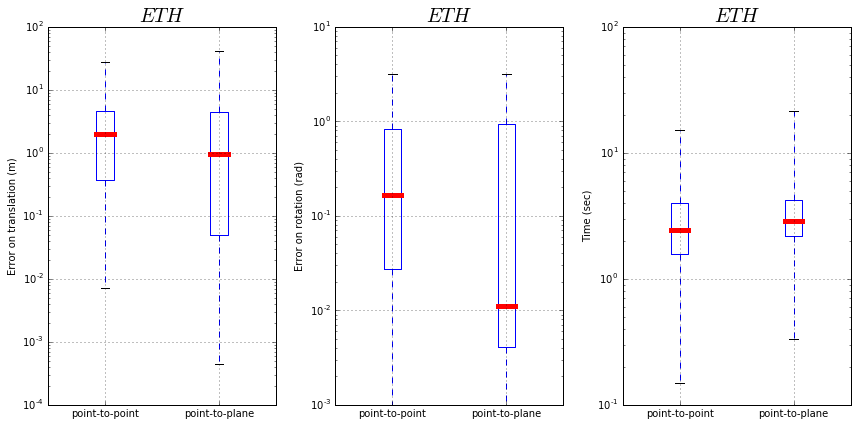

In [233]:
boxprops = dict(linestyle='-', linewidth=1, color='blue')
medianprops = dict(linestyle='-', linewidth=5, color='red')
whiskerprops = dict(linestyle='--', linewidth=1, color='black')

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(131)
plot_data.boxplot([('point-to-point', 'error_trans'), ('point-to-plane', 'error_trans')], 
                  ax=ax1, return_type=None,
                  whis=[0,100], medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops);
ax1.set_xticklabels(solution_names)
ax1.set_title('$\it{' + env_name + '}$', fontsize=20)
ax1.set_ylabel('Error on translation (m)')
ax1.set_yscale('log')

ax2 = fig.add_subplot(132)
plot_data.boxplot([('point-to-point', 'error_rot'), ('point-to-plane', 'error_rot')], 
                  ax=ax2, return_type=None,
                  whis=[0,100], medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops);
ax2.set_xticklabels(solution_names)
ax2.set_title('$\it{' + env_name + '}$', fontsize=20)
ax2.set_ylabel('Error on rotation (rad)')
ax2.set_yscale('log')

ax3 = fig.add_subplot(133)
plot_data.boxplot([('point-to-point', 'time'), ('point-to-plane', 'time')], 
                  ax=ax3, return_type=None,
                  whis=[0,100], medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops);
ax3.set_xticklabels(solution_names)
ax3.set_title('$\it{' + env_name + '}$', fontsize=20)
ax3.set_ylabel('Time (sec)')
ax3.set_yscale('log')

fig.tight_layout(w_pad=2.)

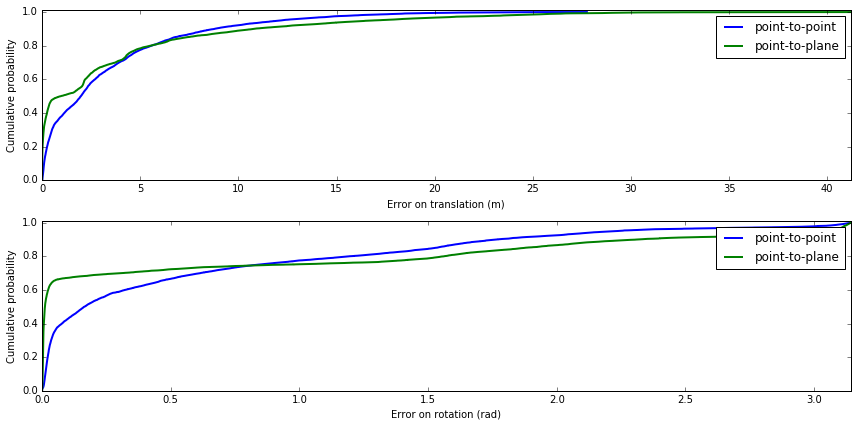

In [223]:
fig = plt.figure(figsize=(12,6))



ax1 = fig.add_subplot(211)
for name in solution_names:
    data = plot_data[name].error_trans.sort(inplace=False).values
    cum_prob = np.linspace(0, 1., len(data))
    ax1.plot(data, cum_prob,
             '-', lw=2 
            );
ax1.set_xlabel('Error on translation (m)')
ax1.set_ylabel('Cumulative probability')
ax1.set_xlim([0., data.max()])
ax1.set_ylim([0., 1.01])
ax1.legend(solution_names)

ax2 = fig.add_subplot(212)
for name in solution_names:
    data = plot_data[name].error_rot.sort(inplace=False).values
    cum_prob = np.linspace(0, 1., len(data))
    ax2.plot(data, cum_prob,
             '-', lw=2 
            );

ax2.set_xlabel('Error on rotation (rad)')
ax2.set_ylabel('Cumulative probability')
ax2.set_xlim([0., data.max()])
ax2.set_ylim([0., 1.01])
ax2.legend(solution_names)

fig.tight_layout()

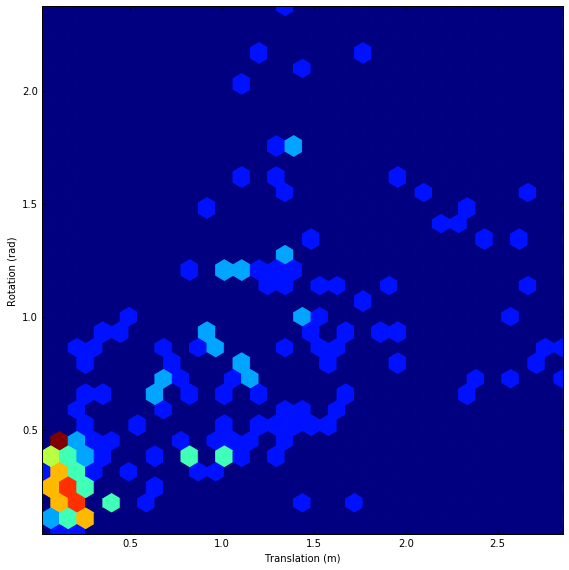

In [216]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.hexbin(plot_data.validation.perturbation_trans.unique(), plot_data.validation.perturbation_rot.unique(), 
           gridsize=30);
ax1.set_xlabel('Translation (m)')
ax1.set_ylabel('Rotation (rad)')
fig.tight_layout()

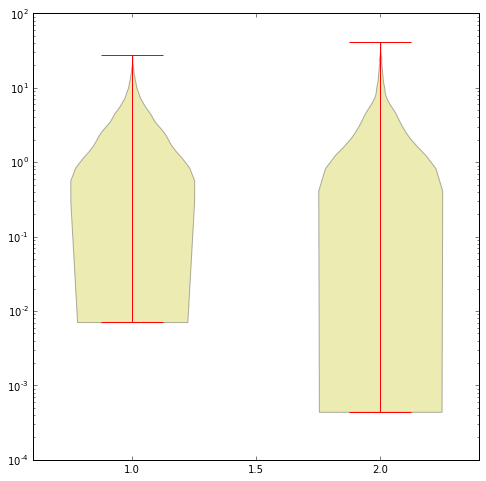

In [234]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.violinplot(plot_data[[('point-to-point', 'error_trans'), ('point-to-plane', 'error_trans')]].values)
ax1.set_yscale('log')

In [237]:
np.min(plot_data[[('point-to-point', 'error_rot')]])

point-to-point  error_rot    0
dtype: float64

In [211]:
plot_data['point-to-point', 'time'].values

array([ 2.3344,  2.9928,  5.9257, ...,  3.8618,  2.7754,  2.2971])